In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, PersistAD, LevelShiftAD, VolatilityShiftAD
from IPython.display import display
from ydata_profiling import ProfileReport

In [28]:
data_cleaned_dir = "../data/aruba/data_cleaned.csv"

df_aruba = pd.read_csv(
    data_cleaned_dir,
    delimiter=",",
    header=0,
    names=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
        "datetime",
    ],
    parse_dates=True,
)

df_aruba["datetime"] = pd.to_datetime(df_aruba["datetime"], format="ISO8601")
# display(df_aruba)
# print(df_aruba.info())
# df_aruba.dtypes

### Filter

In [29]:
generate_sensor_list = lambda n, m: [f"M{str(i).zfill(3)}" for i in range(n, m + 1)]
motion_sensor_list = generate_sensor_list(1, 31)

filter_sensor_group = {
    "all": motion_sensor_list,
    "bedroom": ["M001", "M002", "M003", "M004", "M005", "M006", "M007"],
    "bedroom_in_bed": ["M002", "M003"],
    "bedroom_out_of_bed": ["M001", "M004", "M005", "M006", "M007"],
}

filter_days = {
    "all": [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    "in_the_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
    "weekend": ["Saturday", "Sunday"],
    "mondays": ["Monday"],
    "tuesdays": ["Tuesday"],
    "wednesdays": ["Wednesday"],
    "thursdays": ["Thursday"],
    "fridays": ["Friday"],
    "saturdays": ["Saturday"],
    "sundays": ["Sunday"],
}

### Hilfsfunktionen

In [30]:
def create_data_subset(df: pd.DataFrame, pattern: str) -> pd.DataFrame:
    df_subset = df[df["sensor_type"].str.match(pattern)]
    df_subset.loc[:, "date"] = pd.to_datetime(df_subset["date"])
    df_subset.loc[:, "datetime"] = pd.to_datetime(df_subset["datetime"], format="ISO8601")
    return df_subset


# Regex pattern for motion sensors (e.g., M001, M002, etc.)
pattern_motion_sensor = r"[M]{1}[0-9]{3,}"
pattern_temperature_sensor = r"[T]{1}[0-9]{3,}"
pattern_door_closure_sensor = r"[D]{1}[0-9]{3,}"

In [31]:
def sleep_activity_index(df_input: pd.DataFrame, show_output: bool = True) -> tuple:
    df_copy = df_input.copy()

    # Filter data for the specified range
    df_filtered = df_copy[
        (df_copy["date"] >= date_from)
        & (df_copy["date"] <= date_to)
        & (df_copy["time"] >= time_from)
        & (df_copy["time"] <= time_to)
    ]

    # Ensure data is sorted by sensor and datetime
    df_filtered = df_filtered.sort_values(by=["sensor_type", "datetime"])

    # Initialize an empty list to store results
    results = []

    # Group by each sensor and process
    for sensor, group in df_filtered.groupby("sensor_type"):
        # Reset index for easier access
        group = group.reset_index(drop=True)

        # Iterate through the group to find ON-OFF pairs
        for i in range(len(group) - 1):
            if group.loc[i, "sensor_status"] == "ON" and group.loc[i + 1, "sensor_status"] == "OFF":
                duration = (group.loc[i + 1, "datetime"] - group.loc[i, "datetime"]).total_seconds()
                results.append(
                    {
                        "sensor_type": sensor,
                        "activation_count": 1,
                        "total_active_duration": duration,
                        "datetime": group.loc[i, "datetime"],
                        "next_datetime": group.loc[i + 1, "datetime"],
                        "date": group.loc[i, "date"],
                        "time": group.loc[i, "time"],
                        "sensor_status": group.loc[i, "sensor_status"],
                    }
                )

    # Combine results into a summary DataFrame
    df_sleep_activity = pd.DataFrame(results)
    df_sleep_activity_index = pd.DataFrame()

    # display(df_sleep_activity)

    # Find the total time window for the sensor
    total_time_period = (df_filtered["datetime"].max() - df_filtered["datetime"].min()).total_seconds()

    # Aggregate by sensor_type
    if not df_sleep_activity.empty:
        sensor_summary = (
            df_sleep_activity.groupby("sensor_type")
            .agg(activation_count=("activation_count", "sum"), total_active_duration=("total_active_duration", "sum"))
            .reset_index()
        )

        # Add total_time_period as a constant column
        sensor_summary["total_time_period"] = total_time_period

        # Calculate activity_index
        sensor_summary["activity_index"] = (
            sensor_summary["total_active_duration"] / sensor_summary["total_time_period"]
        ) * 100

        df_sleep_activity_index = pd.DataFrame(sensor_summary)

    if show_output:
        display(df_sleep_activity_index)

    return (df_sleep_activity_index, df_sleep_activity)

### Automatische Anomalieerkennung

In [32]:
# Create a subset for motion sensors
df_motion_sensor = create_data_subset(df_aruba, pattern_motion_sensor)
df_motion_sensor = df_motion_sensor.reset_index(drop=True)

df_motion_sensor.loc[:, "date"] = pd.to_datetime(df_motion_sensor["datetime"]).dt.date
df_motion_sensor.loc[:, "time"] = (
    pd.to_datetime(df_motion_sensor["datetime"], format="%H:%M:%S.%f").dt.floor("s").dt.time
)

df_bedroom = df_motion_sensor.loc[df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom"])]

df_bedroom_in_bed = df_motion_sensor.loc[df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom_in_bed"])]

df_bedroom_out_of_bed = df_motion_sensor.loc[
    df_motion_sensor["sensor_type"].isin(filter_sensor_group["bedroom_out_of_bed"])
]

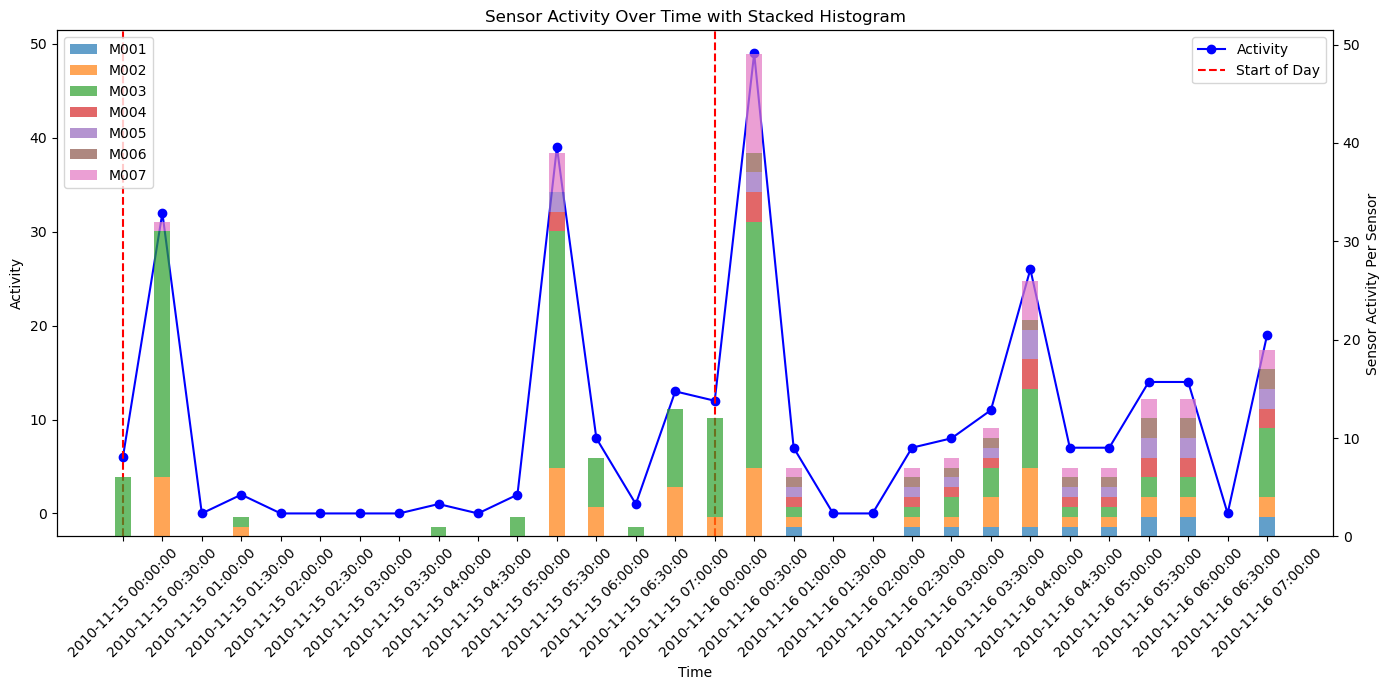

In [ ]:
# Define the date and time ranges
date_from = pd.to_datetime("2010-11-15").date()
date_to = pd.to_datetime("2010-11-30").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:00").time()

period = "30min"

df_activity = pd.DataFrame()

df_activity["activity"] = (
    df_bedroom.loc[df_bedroom["sensor_status"] == "ON"].resample(period, on="datetime")["sensor_status"].count()
)

df_activity["activity_per_sensor"] = (
    df_bedroom.loc[df_bedroom["sensor_status"] == "ON"]
    .resample(period, on="datetime")
    .apply(lambda group: group.groupby("sensor_type").size().to_dict())
)

df_activity["datetime"] = df_activity.index

df_activity = df_activity.reset_index(drop=True)
df_activity["date"] = df_activity["datetime"].dt.date
df_activity["time"] = df_activity["datetime"].dt.time

# List of weekday names
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_activity["weekday"] = df_activity["date"].apply(lambda d: days[d.weekday()])

# Filter data for the specified range
df_filtered = df_activity.loc[
    (df_activity["date"] >= date_from)
    & (df_activity["date"] <= date_to)
    & (df_activity["time"] >= time_from)
    & (df_activity["time"] <= time_to)
]

# Extract unique time points for x-axis
time_points = df_filtered["datetime"].apply(lambda t: t.strftime("%Y-%m-%d %H:%M:%S")).tolist()

# Prepare histogram data
sensor_columns = set()
for sensors in df_filtered["activity_per_sensor"]:
    sensor_columns.update(sensors.keys())
sensor_columns = sorted(sensor_columns)

# Create a DataFrame for stacked histogram
sensor_data = pd.DataFrame(0, index=df_filtered.index, columns=sensor_columns)
for idx, sensors in df_filtered["activity_per_sensor"].items():
    for sensor, count in sensors.items():
        sensor_data.loc[idx, sensor] = count

# Create the plot
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the time-series data
ax1.plot(
    time_points,
    df_filtered["activity"],
    label="Activity",
    color="blue",
    marker="o",
)

# Plot the stacked histogram
bottom = np.zeros(len(sensor_data))
bar_width = 0.4
x_positions = np.arange(len(sensor_data))

for sensor in sensor_columns:
    ax2.bar(
        x_positions,
        sensor_data[sensor],
        bottom=bottom,
        label=sensor,
        width=bar_width,
        alpha=0.7,
    )
    bottom += sensor_data[sensor]

# Add vertical lines for new days
unique_dates = df_filtered["date"].unique()
for date in unique_dates:
    midnight = pd.Timestamp(f"{date} 00:00:00")
    midnight = midnight.strftime("%Y-%m-%d %H:%M:%S")
    ax1.axvline(midnight, color="red", linestyle="--", label="Start of Day" if date == unique_dates[0] else "")

# Customize axes
ax1.set_xlabel("Time")
ax1.set_ylabel("Activity")
ax2.set_ylabel("Sensor Activity Per Sensor")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(time_points, rotation=45)
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

# Title and layout adjustments
plt.title("Sensor Activity Over Time with Stacked Histogram")
plt.tight_layout()
plt.show()

In [50]:
df_activity_train = df_filtered[["datetime", "activity"]]
df_activity_train.loc[:, "datetime"] = pd.to_datetime(df_activity_train["datetime"])  # Ensure it's a datetime object
df_activity_train.set_index("datetime", inplace=True)  # Set 'datetime' as the index
df_filtered_train = validate_series(df_activity_train)

# display(df_activity_train)

#### Anomalieerkennung (ThresholdAD)

[<Axes: >]

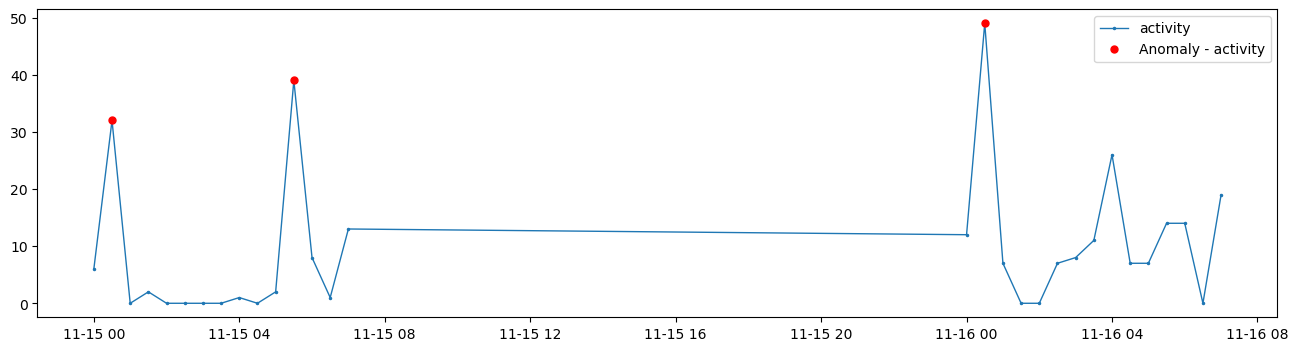

In [58]:
# /opt/conda/lib/python3/site-package/adtk
# python -m compileall .

threshold_ad = ThresholdAD(high=30, low=0)
anomalies = threshold_ad.detect(df_activity_train)

plot(
    df_activity_train,
    anomaly=anomalies,
    ts_linewidth=1,
    ts_markersize=3,
    anomaly_markersize=5,
    anomaly_color="red",
    anomaly_tag="marker",
)

#### Anomalieerkennung (QuantileAD)

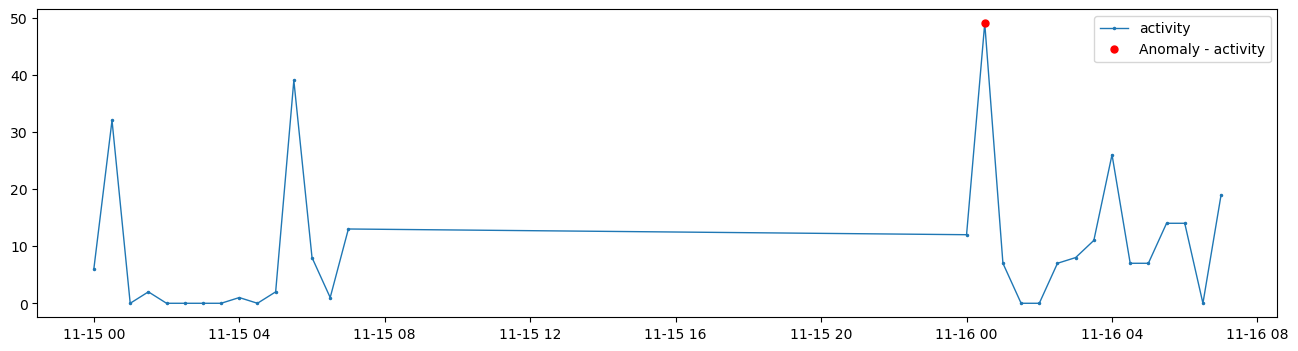

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df_activity_train)

plot(
    df_activity_train,
    anomaly=anomalies,
    ts_linewidth=1,
    ts_markersize=3,
    anomaly_markersize=5,
    anomaly_color="red",
    anomaly_tag="marker",
)

#### Anomalieerkennung (InterQuartileRangeAD)

In [62]:
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(df_activity_train)

[<Axes: >]

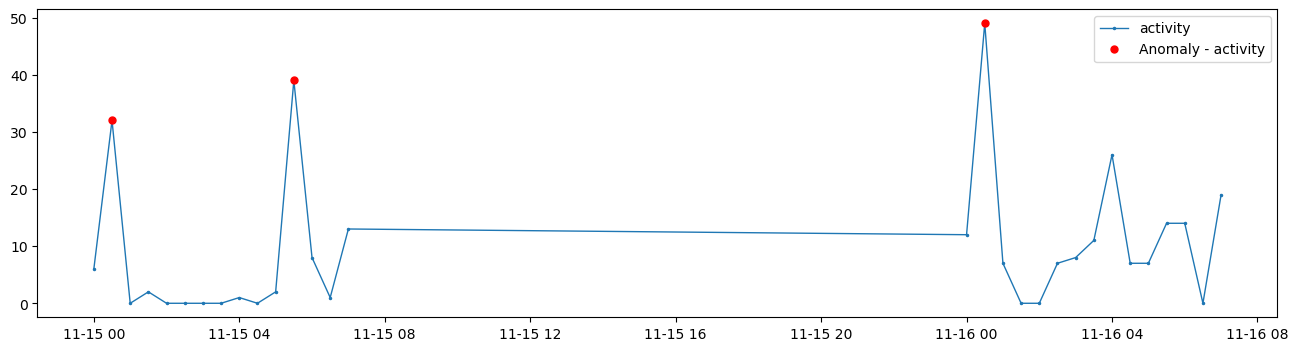

In [64]:
plot(
    df_activity_train,
    anomaly=anomalies,
    ts_linewidth=1,
    ts_markersize=3,
    anomaly_markersize=5,
    anomaly_color="red",
    anomaly_tag="marker",
)

#### Anomalieerkennung (PersistAD)

In [ ]:
persist_ad = PersistAD(c=3.0, side="positive")
anomalies = persist_ad.fit_detect(df_activity_train)
# plot(df_activity_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color="red")

/opt/conda/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/opt/conda/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/opt/conda/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[predicted & lists.isna().any(axis=1)] = 

#### Anomalieerkennung (LevelShiftAD)

/opt/conda/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/opt/conda/lib/python3.12/site-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/opt/conda/lib/python3.12/site-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[predicted & lists.isna().any(axis=1)] = 

AttributeError: 'Series' object has no attribute 'iteritems'

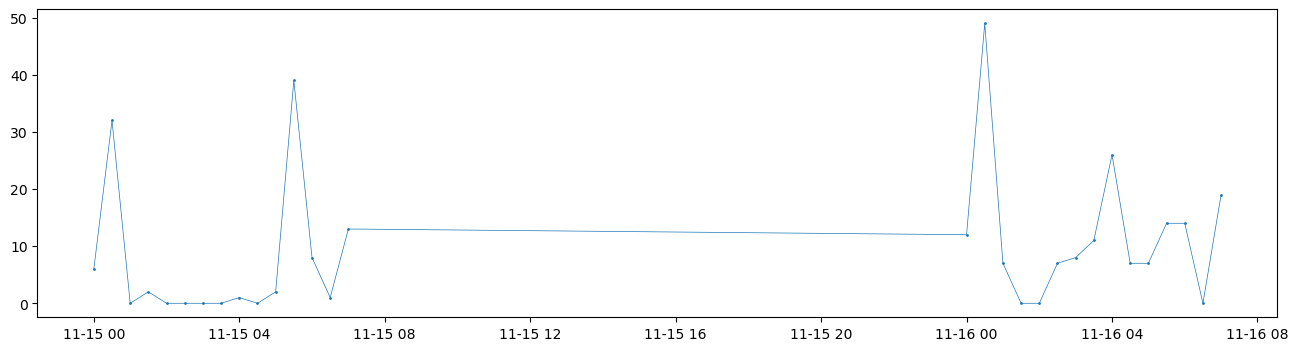

In [68]:
level_shift_ad = LevelShiftAD(c=6.0, side="both", window=5)
anomalies = level_shift_ad.fit_detect(df_activity_train)
plot(df_activity_train, anomaly=anomalies, anomaly_color="red")

#### Anomalieerkennung (VolatilityShiftAD)

In [69]:
volatility_shift_ad = VolatilityShiftAD(c=6.0, side="positive", window=30)
anomalies = volatility_shift_ad.fit_detect(df_activity_train)
plot(df_activity_train, anomaly=anomalies, anomaly_color="red")

RuntimeError: Valid values are not enough for training.